In [1]:
# Using the usual packages, plus scikitlearns LinearRegression tool; and numpy.random.

import pandas as pa
import numpy as np
import numpy.random as rn
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Building a sample with a linear relationship y = 10 x + 7 + E; where E is a random normally 
# distributed error term with mean 0 and variance 200.

x = 500*rn.random_sample(20)
y = 10*x + 7 + 200*rn.randn(20)

In [3]:
# Furthermore let's suppose there are a couple of data points that have a different E for
# some reason 

xa = np.array([700, 300])
ya = np.array([10*700 + 7 - 1500, 10*300 + 7 + 1500])

In [4]:
# Make a pandas.DataFrame of this data

dfx = pa.DataFrame(x, columns=['x'])
dfx['a'] = 0
dfx['y'] = y
dfx2 = pa.DataFrame(xa, columns=['x'])
dfx2['a'] = 1
dfx2['y'] = ya
df = dfx.append(dfx2, ignore_index=True)
df.tail()

,x,a,y
17,236.958932,0,2061.772432
18,467.355539,0,4900.202389
19,352.666710,0,3699.247602
20,700.000000,1,5507.000000
21,300.000000,1,4507.000000


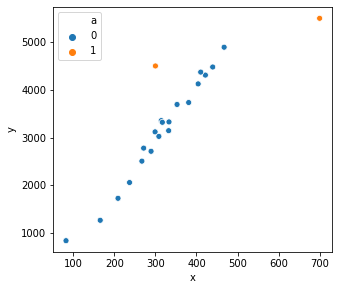

In [6]:
plt.figure(figsize=(5, 4.5))

sn.scatterplot(x='x', y='y', hue='a', data=df);

In [7]:
# First convert the predictor and result variables into numpy.arrays suitable for applying in 
# scikitlearn functions (recall we did this last class)

# We will keep the 'a' flag identifying our special points

X = np.array(df[['x', 'a']])
y = np.array(df['y'])

In [12]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [13]:
# Make sure the a=1 points are in X_train

set(X_test[:, 1])

{0.0}

In [14]:
reg = LinearRegression().fit(X_train[:, 0].reshape(-1, 1), y_train)

In [17]:
b, m = reg.intercept_, *reg.coef_
b, m

(501.3472089481993, 8.469624198966391)

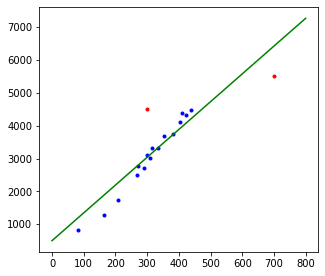

In [18]:
plt.figure(figsize=(5, 4.5))

plt.plot(X_train[X_train[:, 1]==0, 0], y_train[X_train[:, 1]==0], 'b.')
plt.plot(X_train[X_train[:, 1]==1, 0], y_train[X_train[:, 1]==1], 'r.')
x = np.linspace(0, 800, 10)
yhat = m*x + b
plt.plot(x, yhat, 'g-');

In [19]:
# Residual Sum of Squares

yhat = m*X_train[:, 0]+b
RSS = sum( (yhat - y_train)**2 )
RSS

4348706.507257693

Note: We missed the true relationship, particularly the intercept. Why?

Of course this total error (*Residual Sum of Squares*) is not a great measure of how good our model was, as obviously it depends on the magnitudes and variations of the sample $y_i$. 

The *Total Variance* is given by the sum of the squares of the differences of the training data and the mean of the training data. 

In [20]:
y_mean = np.mean(y_train)
TV = sum( (y_train - y_mean)**2 )
TV

24939680.1334349

If the regression line correctly explains the variations of the data, i.e. if our model correctly accounts for all of the errors relative to the extent to which the $y_i$ vary anyway, then the ratio of *Residual Sum of Squares* to *Total Variance* will be small; $R^2$ is defined to be 1 minus this ratio. Notice though that if the Total Variance is large compared to the Residual Sum of Squares this will also result in an $R^2$ that is near 1. 

In [22]:
R2 = 1 - RSS/TV
R2

0.8256310231730806

Note each time we run the cells above, with the dataset fixed, for this computation we will get slightly different values of $m$, $b$, and $R^2$. This is because the division into training and testing sets is different each time.

### Checking the Influence of Individual Points

Note that we have, or suspect we have, some samples that do not fit the same pattern as the rest of the data. An important question is to consider the impact that these samples have on the model we have computed. We do that by computing the linear regression with each point removed. Normally we would not know what points do not fit with the others (though we may have suspicions) so the best practice is to go through all of them.


In [23]:
n = X_train.shape[0]
lin_reg = [0 for k in range(n)]
R2p = [0 for k in range(n)]
for k in range(n):
    Xtemp = np.append(X_train[:k], X_train[k+1:], axis=0)
    ytemp = np.append(y_train[:k], y_train[k+1:], axis=0)
    lin_reg[k] = LinearRegression().fit(Xtemp[:, 0].reshape(-1, 1), ytemp)
    kRSS = sum( (lin_reg[k].predict(X_train[:, 0].reshape(-1, 1)) - y_train)**2 ) 
    R2p[k] = 1 - kRSS / TV

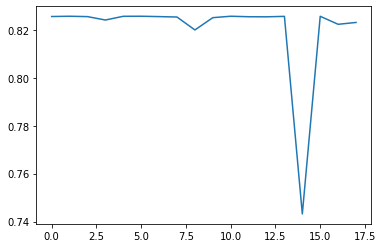

In [24]:
plt.plot(range(n), R2p);  # Plot the sizes of the R2s

In [25]:
min(R2p), R2    # Compare the values of R2

(0.7431955213867025, 0.8256310231730806)

In [26]:
m1 = R2p.index(min(R2p)) # Note the location of the minimum
X_train[m1, :] 

# And we see that the off-pattern value at x=700 gives the minimum R2

array([700.,   1.])

This indicates that this sample has a disproportionate impact on our model. That should make us supicious that there is overfitting being caused by it.

The coefficients without the first one are given below.

In [27]:
b2, m2 = lin_reg[m1].intercept_, *lin_reg[m1].coef_
b2, m2

(-226.55382129594818, 11.001992449271624)

Points with much different $y$ values from other $y$ values with similar $x$ values (*outliers*), or points with much different $x$ values from the mean of the $x$ values (*high leverage samples*) have the potnetial to impact the model disproportinately like both of these. It is tempting to treat them differently (i.e. to accept the model computed without them). However we must proceed with caution. These samples may be the result of some error in the data collection, however they may also be valid samples.

Should we include them or not?  A model that has been greatly swayed by a high leverage point may not perform as well on the test data because it has been overfit to these samples. However these high leverage and outlier samples may also be indicative of a pattern in the data. The thing that should give us pause is what happened with the water samples in Flint, MI.

### Using the Test Set

Of course we prepared for this by sequestering some of our data from the training (development) of our model. We can now use this data to check how accurate our model is on data it has not seen. We will run the test on the model computed with all of the training points $(b, m)$, and on the model computed without the outlier point $(b_2, m_2)$. What erorr expression should we use? We have the ready made one given by the *Residual Sum of Squares* and $R^2$. 


In [29]:
# Residual Sum of Squares of the Training and Testing Sets

yhat_train = m*X_train[:, 0] + b
RSS_train = sum( (yhat_train - y_train)**2)

yhat_test = m*X_test[:, 0] + b
RSS_test = sum( (yhat_test - y_test)**2)

'Residual Sum of Squares for Train and Test: {:.0f}, {:.0f}'.format(RSS_train, RSS_test)

'Residual Sum of Squares for Train and Test: 4348707, 460333'

Note right away this shows why *Residual Sum of Squares* is problematic - because the sample sizes are different between testing and training sets these numbers are incomparable.

In [30]:
# Compute R2 of the Training and Testing Sets

y_train_mean = np.mean(y_train)
TV_train = sum( (y_train - y_train_mean)**2)
R2_train = 1 - RSS_train / TV_train

y_test_mean = np.mean(y_test)
TV_test = sum( (y_test - y_test_mean)**2)
R2_test = 1 - RSS_test / TV_test

'R2 for Train and Test: {}, {}'.format(R2_train, R2_test)

'R2 for Train and Test: 0.8256310231730806, 0.8877719612134526'

Now lets do the same computation for the second regression expression and see if there is a difference:

In [31]:
yhat_train = m2*X_train[:, 0] + b2
RSS_train = sum( (yhat_train - y_train)**2)

yhat_test = m2*X_test[:, 0] + b2
RSS_test = sum( (yhat_test - y_test)**2) 

y_train_mean = np.mean(y_train)
TV_train = sum( (y_train - y_train_mean)**2)
R2_train_2 = 1 - RSS_train / TV_train

y_test_mean = np.mean(y_test)
TV_test = sum( (y_test - y_test_mean)**2)
R2_test_2 = 1 - RSS_test / TV_test

'R2 for Train and Test (model 2): {}, {}'.format(R2_train_2, R2_test_2)

'R2 for Train and Test (model 2): 0.7431955213867025, 0.9519912587667273'

### Understanding Training and Testing Error

So remember our model has been choosen, under the restriction of being a linear model, to minimize the training error (giving us the $R^2$ closest to 1). It has never seen the testing data. So we typically expect the testing error to be worse than the training error. Note that the model did better on the testing data without the high impact point. If you increase the size of the sample following the pattern, this difference will decrease.

## Error in Categorization Problems

Consider a categorization problem, this dataset is a collection of data related to study of chronic kidney disease (from the UCI archive). 


In [32]:
kd = pa.read_csv('Data Sets/Kidney/chronic_kidney_disease.csv', 
                 names=['age', 'bp', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
                        'pus_cell_clumps', 'bacteria', 'blood_glucose', 'blood_urea', 'serum_creatinine', 
                        'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
                        'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
                        'appetite', 'pedal_edema', 'anemia', 'class'])

kd.loc[kd.loc[:, 'class'] == 'ckd\t', 'class'] = 'ckd'  # There is an extra tab character on some of the ckd values

kd.head()

,age,bp,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [33]:
# There are some missing values for hemoglobin

kd = kd[kd.hemoglobin != '?']  

Note that the goal here is to determine a hemoglobin level that indicates that a patient has *Chronic Kidney Disease*.

### Logistic Regression (Classification)

We first need to develop a model for classification to discuss how error in categorization models is handled. Our first example of a categorization model is a generalization of the *Linear Regression* model we were using above. 

We will consider two models. The first is based on the linear interpolation we used above, and is what we might consider a *naive* generalization. The second is *Logistic Regression*, which despite its name, is derived first as a classification method.

In order to compare our two methods, we will use the *test* set method we introduced above and set aside a portion of our samples to use to train or develop the models and a separate portion to use for testing the models.

In [35]:
# First convert the data to numerical data in numpy arrays
# Note a problem with this data is that the float values for hemoglobin (and other variables) were read as strings
# We need to convert them

X = np.atleast_2d(np.array([float(h) for h in kd.loc[:, 'hemoglobin']])).transpose()

# We need to recode the values for the class to be numeric
rename_class = { 'ckd':1, 'notckd':0}  
y = np.array([rename_class[c] for c in np.array(kd.loc[:, 'class'])])


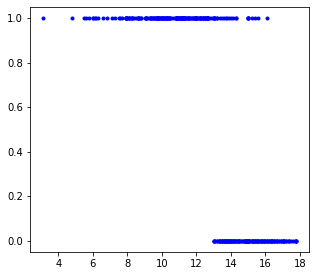

In [36]:
plt.figure(figsize = (5, 4.5))
plt.plot(X, y, 'b.');

Note that other than the fact that the $y$ values take only 0 or 1 values, this is a similar problem to the regression problem above. So we could try Linear Regression. First we divide the data into testing and training sets.

In [37]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [38]:
reg = LinearRegression().fit(X_train, y_train)

b, m = reg.intercept_, *reg.coef_
b, m

(2.239904381146117, -0.13231302964234823)

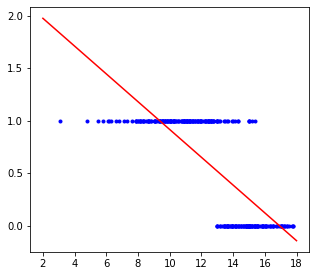

In [40]:
xhat = np.linspace(2, 18, 100)
yhat = m*xhat+b
plt.figure(figsize = (5, 4.5))
plt.plot(X_train, y_train, 'b.')
plt.plot(xhat, yhat, 'r-');

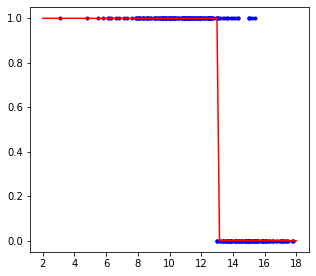

In [42]:
# we round the resulting y values to get the nearest value of 1 or 0

xhat = np.linspace(2, 18, 100)
fix_yhat = {2:1, 1:1, 0:0}
yhat = [fix_yhat[h] for h in np.round(m*xhat+b)]
plt.figure(figsize = (5, 4.5))
plt.plot(X_train, y_train, 'b.')
plt.plot(xhat, yhat, 'r-');

The decision boundary is where $y =  mx + b = 0.5$. 

In [43]:
dec_boundary = (0.5 - b)/m
dec_boundary

13.14990961849491

The points to the left of the decision boundary can be classified as Chronic Kidney Disease, those to the right as healthy. However note that there will be some samples that are misclassified. The proportion of the sample (training and testing separately) that is misclassified is the error.

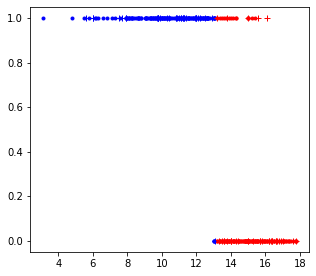

In [44]:
plt.figure(figsize = (5, 4.5))

plt.plot(X_train[(X_train < dec_boundary)[:, 0]], y_train[(X_train < dec_boundary)[:, 0]], 'b.');
plt.plot(X_train[(X_train > dec_boundary)[:, 0]], y_train[(X_train > dec_boundary)[:, 0]], 'r.');
plt.plot(X_test[(X_test < dec_boundary)[:, 0]], y_test[(X_test < dec_boundary)[:, 0]], 'b+');
plt.plot(X_test[(X_test > dec_boundary)[:, 0]], y_test[(X_test > dec_boundary)[:, 0]], 'r+');

In [45]:
Error_train = (sum( y_train[(X_train < dec_boundary)[:, 0]] == 0 ) + 
               sum( y_train[(X_train > dec_boundary)[:, 0]] == 1) )/y_train.shape[0]
Error_test = (sum( y_test[(X_test < dec_boundary)[:, 0]] == 0 ) + 
               sum( y_test[(X_test > dec_boundary)[:, 0]] == 1) )/y_test.shape[0]

print('Training Error: {}'.format(Error_train))
print('Testing Error: {}'.format(Error_test))

Training Error: 0.06451612903225806
Testing Error: 0.08695652173913043


#### The Logistic Model

Note though that what we have done does not really make a lot of sense. We have used a linear best fit line to try and predict the values of the categorical variable $y$. In this case $y$ only takes values $1$ or $0$ and so it is not to far off, however if we had a categorical variable with 3 or more values coding them as integers may not correspond to their relationship. For one thing they might not even be ordered!

What we need is a method of categorization that is built on the categorical problem itself. 

What we are trying to predict is the probability that a patient has *Chronic Kidney Disease* given a hemoglobin level $x$.

$$ p(x) = P(y=1 | x) $$

Note that with *Linear Regression* what we have attempted to do is estimate this probability with a linear function:

$$ p(x) = P(y=1 | x) = m x + b $$

But immediately notice the problem, this returns values bigger than 1 and less than 0 for some choices of $x$.

So what we would prefer is to estimate $p(x) = P(y=1 | x) $ with some function that only returns values between 0 and 1 and thus gives a valid probability. We could use the logistic function:

$$ p(x) = P(y=1 | x) = \frac{\exp(m x + b)}{1 + \exp(m x + b)} $$

You may have seen this function before in modeling population growth with a carrying capacity.

So the idea is to find values of $m$ and $b$ that give the best estimate for $p(x)$ that we can find.

We will skip for now how these values are actually computed and instead use the scikitlearn function LogisticRegression.

In [46]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

In [47]:
# Make an instance of the model and fit it to the training data
lgreg = LogisticRegression(solver='lbfgs')
lgreg.fit(X_train, y_train);

In [48]:
b, m = *lgreg.intercept_, *lgreg.coef_[0]
b, m

(24.125596466650805, -1.7904325456464814)

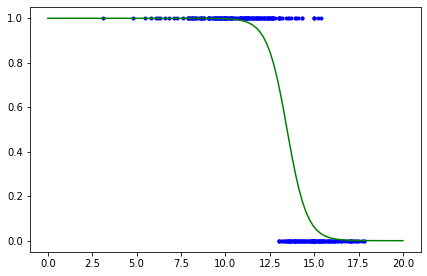

In [51]:
plt.figure(figsize = (7, 4.5))
plt.plot(X_train, y_train, 'b.')
xx = np.linspace(0, 20, 100)
yy = np.exp(m*xx+b)/(1 + np.exp(m*xx+b))
plt.plot(xx, yy, 'g-');

The decsision boundary happens again where the probability becomes 0.5; although note that we could actually tune the location of the decsision boundary based on the extent to which we want to avoid false positives or false negatives.

In [52]:
dec_bd = -b/m  # Solving for the logistic function = 0.5 gives - b/m
dec_bd

13.474730743313003

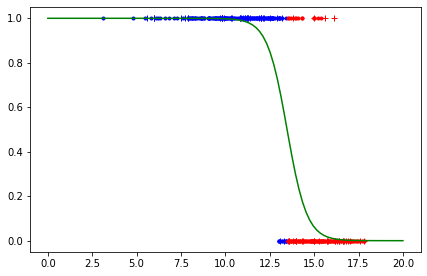

In [53]:
# Plotting the classification of the training and testing sets.

plt.figure(figsize = (7, 4.5))

plt.plot(X_train[(X_train < dec_bd)[:, 0]], y_train[(X_train < dec_bd)[:, 0]], 'b.')
plt.plot(X_train[(X_train > dec_bd)[:, 0]], y_train[(X_train > dec_bd)[:, 0]], 'r.')
plt.plot(X_test[(X_test < dec_bd)[:, 0]], y_test[(X_test < dec_bd)[:, 0]], 'b+')
plt.plot(X_test[(X_test > dec_bd)[:, 0]], y_test[(X_test > dec_bd)[:, 0]], 'r+')
plt.plot(xx, yy, 'g-');

In [54]:
# Computing the error of the training and testing sets.

Error_train = (sum( y_train[(X_train < dec_bd)[:, 0]] == 0 ) + 
               sum( y_train[(X_train > dec_bd)[:, 0]] == 1) )/y_train.shape[0]
Error_test = (sum( y_test[(X_test < dec_bd)[:, 0]] == 0 ) + 
               sum( y_test[(X_test > dec_bd)[:, 0]] == 1) )/y_test.shape[0]

print('Training Error: {}'.format(Error_train))
print('Testing Error: {}'.format(Error_test))

Training Error: 0.07885304659498207
Testing Error: 0.08695652173913043


In this case the error was comparable, and slightly better (although it changes each time you run it). The logistic model is more robust and fluctuates less than the linear regression model. 

In future weeks we will get into the details of how these models work.